# Summary notebook of the main results

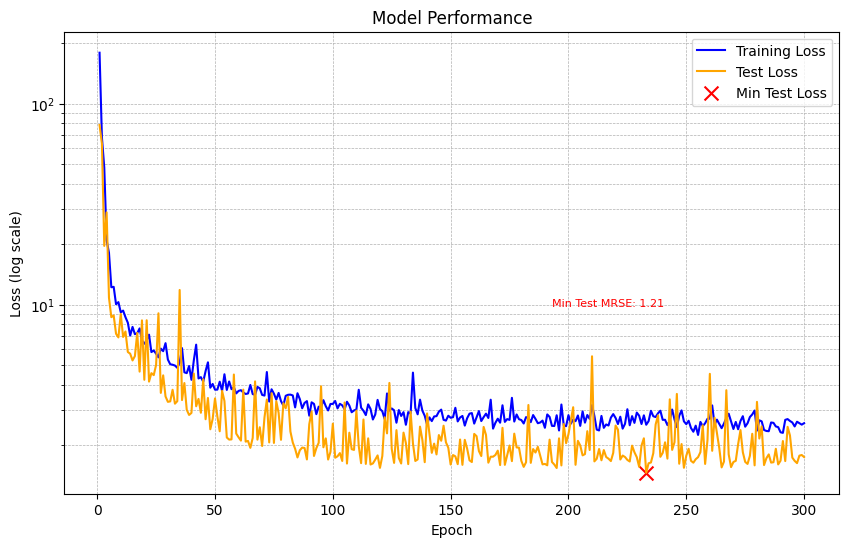

In [10]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store extracted data
epochs = []
batches = []
batch_losses = []
train_losses = []
test_losses = []

run_name = 'adam_b16_dropout30'

# Read the log file line by line
with open("/zhome/52/6/202465/02456_grp_67_project_4/wandb/" + run_name + "/files/output.log", "r") as file:
    for line in file:
        # Match EPOCH lines to extract the epoch number
        epoch_match = re.match(r"EPOCH (\d+):", line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
        
        # Match batch loss lines to extract batch number and loss
        batch_match = re.match(r"\s+batch (\d+) loss: ([\d.]+)", line)
        if batch_match:
            batch_num = int(batch_match.group(1))
            loss = float(batch_match.group(2))
            # Append each batch data with the current epoch number
            epochs.append(current_epoch)
            batches.append(batch_num)
            batch_losses.append(loss)
        
        # Match the final train and test loss per epoch
        train_loss_match = re.match(r"LOSS train ([\d.]+) ; LOSS test ([\d.]+)", line)
        if train_loss_match:
            train_losses.append(float(train_loss_match.group(1)))
            test_losses.append(float(train_loss_match.group(2)))

# Create DataFrame for batch losses
batch_df = pd.DataFrame({
    "Epoch": epochs,
    "Batch": batches,
    "Batch Loss": batch_losses
})

# Create DataFrame for epoch-wise train and test losses
epoch_df = pd.DataFrame({
    "epoch": range(1, len(train_losses) + 1),
    "train_loss": train_losses,
    "test_loss": test_losses
})

df = epoch_df

# Identify the minimum test loss and its corresponding epoch
min_test_loss = df['test_loss'].min()
min_test_loss_mrse = np.sqrt(min_test_loss)  # Calculate MRSE of the minimum test loss
min_test_loss_epoch = df[df['test_loss'] == min_test_loss]['epoch'].iloc[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', color='blue')
plt.plot(df['epoch'], df['test_loss'], label='Test Loss', color='orange')
plt.scatter(min_test_loss_epoch, min_test_loss, color='red', marker='x', s=100, label='Min Test Loss')

# Annotate the minimum test loss MRSE point
plt.annotate(f'Min Test MRSE: {min_test_loss_mrse:.2f}',
             xy=(min_test_loss_epoch, min_test_loss),
             xytext=(min_test_loss_epoch - 40, min_test_loss * 6.75),
             fontsize=8, color='red')

# Customizing the plot
plt.xscale('linear')
plt.yscale('log')  # Log scale for the y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Model Performance')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Save the figure
plt.show()
#plt.savefig(run_name + ".jpg", format="jpg", dpi=300)

